# Аналитика интернет-магазина

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга подготовил список гипотез для увеличения выручки. 

Необходимо:
- приоритизировать гипотезы,
- запустить A/B-тест,
- проанализировать результаты.


* * * * *

**План действий для выполнения поставленной задачи:**<br>
[1. Загрузить данные и изучить общую информацию](#1) <br><br>
[2. Приоритизация гипотез.](#2)<br><br>
    [2.1. ICE](#2.1)<br>
    [2.2. RICE](#2.2)<br><br>
[3. Анализ A/B-теста](#3)<br><br>
[3.1. Построить график кумулятивной выручки по группам.](#3.1)<br>
[3.2. Построить график кумулятивного среднего чека по группам.](#3.2)<br>
[3.3. Построить график относительного изменения кумулятивного среднего чека группы B к группе A.](#3.3)<br>
[3.4. Построить график кумулятивной конверсии по группам.](#3.4)<br>
[3.5. Постройте график относительного изменения кумулятивной конверсии группы B к группе A.](#3.5)<br>
[3.6. Построить точечный график количества заказов по пользователям.](#3.6)<br>
[3.7. Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.](#3.7)<br>
[3.8. Построить точечный график стоимостей заказов.](#3.8)<br>
[3.9. Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.](#3.9)<br>
[3.10. Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным.](#3.10)<br>
[3.11. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.](#3.11)<br>
[3.12. Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным.](#3.12)<br>
[3.13. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.](#3.13)<br><br>
[4. Принять решение по результатам теста и объяснить его.](#4)<br><br>

**Описание данных:**


**Датасет `hypothesis`:**

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Датасет `orders`:**

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

**Датасет `visitors`:**

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

<a id="1"></a>
### Шаг 1. Загрузить данные и изучить общую информацию

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
import seaborn as sns
sns.set(color_codes=True)


hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

for data in [hypothesis, orders, visitors]:
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

**Столбцы date в датасетах orders, visitors имеют тип данных object, хотя там содержится информацией о дате. Заменим тип данных на datetime.**

In [ ]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
for column in [orders['date'], visitors['date']]:
    print(column.dtype)

datetime64[ns]
datetime64[ns]


**Проверим есть ли дубликаты в датасетах hypothesis, orders, visitors:**

In [ ]:
for data in [hypothesis, orders, visitors]:
    print('Количество дубликатов в таблице:', data.duplicated().sum(), end='\n\n')

Количество дубликатов в таблице: 0

Количество дубликатов в таблице: 0

Количество дубликатов в таблице: 0



In [ ]:
for data in [hypothesis, orders, visitors]:
    display(data.sample(5))

,Hypothesis,Reach,Impact,Confidence,Efforts
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


,transactionId,visitorId,date,revenue,group
837,769008348,583433650,2019-08-08,5840,B
698,429858801,3984495233,2019-08-05,14495,A
538,1703637902,4251087345,2019-08-04,4880,B
585,3301293313,1151477821,2019-08-20,4008,B
704,1185885568,759473111,2019-08-07,19520,A


,date,group,visitors
61,2019-08-31,B,718
23,2019-08-24,A,395
8,2019-08-09,A,617
40,2019-08-10,B,369
25,2019-08-26,A,722


#### Вывод:
- В распоряжении находятся три таблицы: hypothesis - информация о 9-ти гипотезах; orders - информация о 1197-ми заказах, полученная в ходе A/B теста; visitors - информация о 62-х пользователях, полученная в ходе A/B теста
- Дубликатов в таблицах нет;
- Пропущенных значений в таблицах нет;
- Заменили тип данных в столбцах orders['date'], visitors['date'] на datetime. В остальных столбцах тип данных корректный.

<a id="2"></a>
#### Шаг 2. Приоритизация гипотез.

<a id="2.1"></a>
#### 2.1. ICE

**Применим фреймворк ICE для приоритизации гипотез.**

In [ ]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis = hypothesis.sort_values(by='ICE', ascending=False).round(2)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00


**Вывод: По методку ICE самая перспективная гипотеза №8 (скидка на день рождения), затем идут гипотезы №0 (добавление каналов привлечение трафика), №7 (добавить форму подписки) и № 6 (показать на главной странице баннер)**

<a id="2.2"></a>
#### 2.2. RICE

**Применим фреймворк RICE для приоритизации гипотез.**

In [ ]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'])
hypothesis = hypothesis.sort_values(by='RICE', ascending=False).round(2)
pd.set_option('max_colwidth', 150)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


**Вывод:**
- **Лидер сменился, теперь самой перспективной является гипотеза №7, затем идут гипотезы №2 (добавить блок рекомендаций товаров), №0 и №6**
- **Гипотеза №8 (скидка на день рождения), которая была лидером при методике ICE, сейчас только на 5-ом месте. Что вполне логично, т.к. у нее очень низкий охват**
- **Также после учета охвата понизился рейтинг у следующих гипотез: №0, №1, №5**
- **Повысился рейтинг у гипотез: №2, №3, №7**
- **Без изменений остался рейтинг у гипотез: №4, №6**

**Резюмируя: будем проводить A/B тест гипотезы №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"**

<a id="3"></a>
### Шаг 3. Анализ A/B-теста.

In [ ]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [ ]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<a id="3.1"></a>
#### 3.1. Построить график кумулятивной выручки по группам. Сделать выводы и предположения.

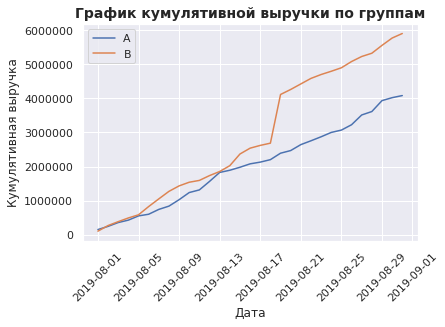

In [ ]:
import warnings
warnings.simplefilter("ignore")

datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups\
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                           orders['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 
          'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)\
    .sort_values(by=['date','group'])

visitorsAggregated = datesGroups\
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                 visitors['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
    .sort_values(by=['date','group'])

cumulativeData = ordersAggregated\
    .merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.title('График кумулятивной выручки по группам', fontweight='bold', fontsize=14)
plt.show()

- Выручка почти равномерно увеличивается в течение всего теста;
- В середине теста у графика группы В замечен резкий скачок вверх, возможно аномальные заказы повлияли на результат. В дальнейшем данные нужно очистить от выбросов.

<a id="3.2"></a>
#### 3.2. Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.

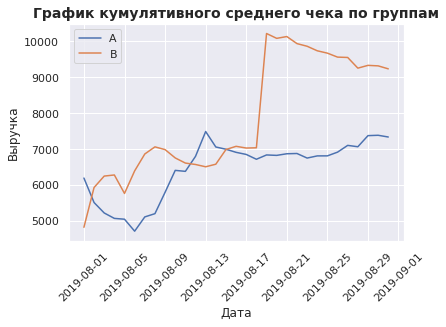

In [ ]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'],
         label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'],
         label='B')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('График кумулятивного среднего чека по группам', fontweight='bold', fontsize=14)
plt.show()

- Также как и по графику конверсии, у группы В есть резкий скачок вверх. В дальнейшем данные нужно очистить от выбросов.
- графики кумулятивного среднего чека сильно колебаются, пока выводов делать рано, возможно влияние оказывают аномальные значения. Избавимся от них в дальнейшем.

<a id="3.3"></a>
#### 3.3. Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.

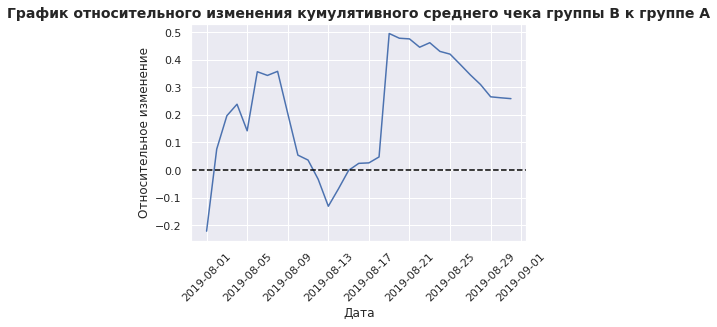

In [ ]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA\
    .merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', 
          fontweight='bold', fontsize=14)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

- Результаты значительно и резко менялись несколько раз, возможно именно в эти даты были совершены аномальные заказы.

<a id="3.4"></a>
#### 3.4. Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.

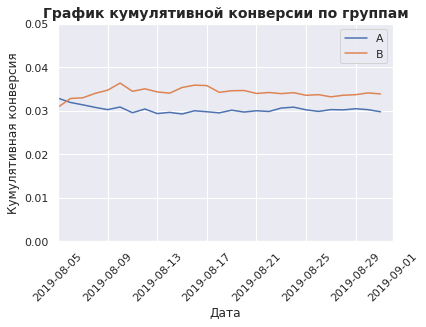

In [ ]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-05", '2019-09-01', 0, 0.05])
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.title('График кумулятивной конверсии по группам', fontweight='bold', fontsize=14)
plt.show()

- В начале теста группа А имела большую конверсию, чем группа В, но затем группа В постепенно опередила группу А и зафиксировалась около одного значения.
- Группа А в начале теста постепенно снизилась и также зафиксировалась около одного значения.

<a id="3.5"></a>
#### 3.5. Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.

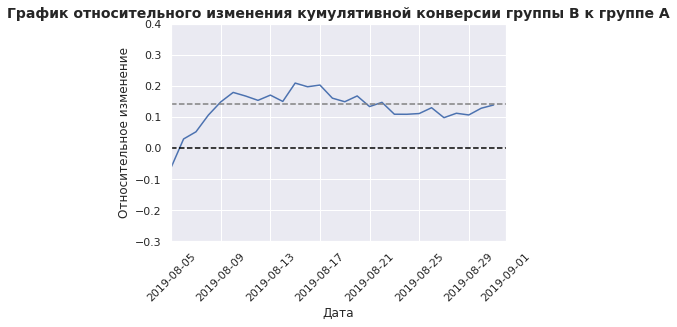

In [ ]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', 
           how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')
plt.axis(["2019-08-05", '2019-09-01', -0.3, 0.4])
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', 
          fontweight='bold', fontsize=14)
plt.show()

- С самого начала теста группа B становится лучше, а затем зафисировалась около прироста конверсии примерно в 14%. 

<a id="3.6"></a>
#### 3.6. Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


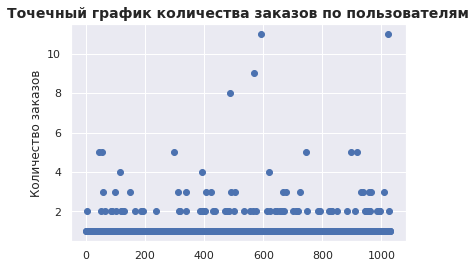

In [ ]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1)\
    .groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['visitorId','orders']

print(ordersByUsers.sort_values(by='orders',ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.ylabel('Количество заказов')
plt.title('Точечный график количества заказов по пользователям', fontweight='bold', fontsize=14)
plt.show()

- Пользователей заказавших более 2 раз совсем мало. Они вполне могут быть аномальными.

<a id="3.7"></a>
#### 3.7. Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [ ]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 4.]


- Не более 5% пользователей совершали более двух заказов и не более 1% пользователей - больше четырех заказов.

<a id="3.8"></a>
#### 3.8. Построить точечный график стоимостей заказов. Сделать выводы и предположения.

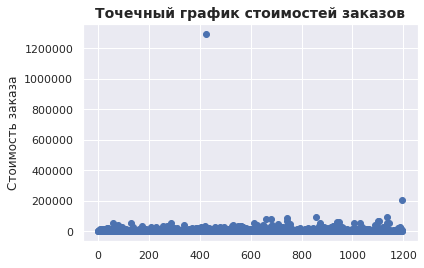

In [ ]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказа')
plt.title('Точечный график стоимостей заказов', fontweight='bold', fontsize=14)
plt.show()

- Заметны явные выборсы в районе 200 000 у.е. и свыше 1 200 000 у.е.
- Заказов стоимостью более 100 000 совсем мало.

<a id="3.9"></a>
#### 3.9. Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.

In [ ]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


- Не более, чем у 5% заказов чек дороже 28 000 у.е. И не больше, чем у 1% - дороже 58 233,2 у.е.

<a id="3.10"></a>
#### 3.10. Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.

**Проверка гипотезы: конверсия между группами различается** <br>
- `H0` - Нулевая гипотеза: **статически значимые различия** в конверсии между группами **отсутствуют**. <br> 
- `H1` - Альтернативная гипотеза: **статически значимые различия** в конверсии между группами **есть**. <br>
- `alpha` - уровень значимости для проверки гипотез примем 5%  <br>
- Т.к. в данных присутствуют выбросы, алгебраические метрики работают плохо. Воспользуемся в таком случае непараметрическим тестом Уилкоксона-Манна-Уитни.

In [ ]:
# количество пользователей в выбранную дату в группе A
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# количество пользователей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily\
        .apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]\
        .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# количество пользователей в выбранную дату в группе В
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# количество пользователей до выбранной даты включительно в группе В
visitorsBCummulative = visitorsBDaily\
        .apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]\
        .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# количество заказов и суммарная выручка в выбранную дату в группе A
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
        .groupby('date', as_index=False)\
        .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# количество заказов и суммарная выручка до выбранной даты включительно в группе А 
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

# количество заказов и суммарная выручка в выбранную дату в группе В
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
        .groupby('date', as_index=False)\
        .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# количество заказов и суммарная выручка до выбранной даты включительно в группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
        .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

# Объединяем данные в одной таблице
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.head(2)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294


Расшифровка названий столбцов:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [ ]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['visitorId', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False)\
                .agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False)\
                .agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders'] 

# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп 
# будет соответствовать количество заказов.
#Тем, кто ничего не заказал, будут соответствовать нули. 
# Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA']\
                .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB']\
                .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 
print('Группа A:', sampleA.sort_values(ascending=False).head())
print()
print('Группа B:', sampleB.sort_values(ascending=False).head())

Группа A: 499    7
278    5
227    5
23     4
18     4
Name: orders, dtype: int64

Группа B: 340    6
326    5
501    4
580    4
424    4
Name: orders, dtype: int64


In [ ]:
# Функция для проверки гипотезы:
def testing(sampleA, sampleB, alpha):
    pvalue = stats.mannwhitneyu(sampleA, sampleB)[1]
    print("p-value: {0:.3f}".format(pvalue))
    if (pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
        
testing(sampleA, sampleB, 0.05)

print("Относительное различие в конверсии между группами по «сырым» данным: {0:.1%}"\
    .format((data['ordersPerDateB'].sum()/data['visitorsPerDateB']\
    .sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

p-value: 0.008
Отвергаем нулевую гипотезу
Относительное различие в конверсии между группами по «сырым» данным: 13.8%


**Значит, по "сырым" данным имеются статистически значимые различия в конверсии между группами.** 

<a id="3.11"></a>
#### 3.11. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.

**Проверка гипотезы: средний чек между группами различается** <br>
- `H0` - Нулевая гипотеза: **статически значимые различия** в среднем чеке заказа между группами **отсутствуют**. <br> 
- `H1` - Альтернативная гипотеза: **статически значимые различия** в среднем чеке заказа между группами **есть**. <br>
- `alpha` - уровень значимости для проверки гипотез примем 5%  <br>
- Т.к. в данных присутствуют выбросы, алгебраические метрики работают плохо. Воспользуемся в таком случае непараметрическим тестом Уилкоксона-Манна-Уитни.

In [ ]:
print('Группа A:', orders[orders['group']=='A']['revenue'].sort_values(ascending=False).head())
print()
print('Группа B:', orders[orders['group']=='B']['revenue'].sort_values(ascending=False).head())

Группа A: 858     93940
1136    92550
662     78990
743     67990
1103    66350
Name: revenue, dtype: int64

Группа B: 425     1294500
1196     202740
744       86620
682       78990
940       58550
Name: revenue, dtype: int64


In [ ]:
testing(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], 0.05)
print("Относительное различие в среднем чеке заказа между группами по «сырым» данным: {0:.1%}"
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue']
              .mean()-1)) 

p-value: 0.365
Не получилось отвергнуть нулевую гипотезу
Относительное различие в среднем чеке заказа между группами по «сырым» данным: 25.9%


**Значит, по "сырым" данным статически значимых различий в среднем чеке между группами нет.** Хотя относительный выигрыш среднего чека группы В равен 25,9% (это странно).

<a id="3.12"></a>
#### 3.12. Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.

Очистим данные от аномалий.    
Ранее мы подсчитали, что 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233,2 у.е. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.
Примем за аномальных пользователей тех, кто совершил 4 заказа и более, или совершил заказ на сумму свыше 58 233 рублей. Так мы уберем 1% пользователей с наибольшим числом заказов и 1% заказов с наибольшей стоимостью.

In [ ]:
# срез пользователей с числом заказов больше 3-х
usersWithManyOrders = (pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'], 
                                ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorId']], axis = 0))
# срез пользователей, совершивших заказы дороже 58 233 у.е.
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorId']
# Объединим их в таблице abnormalUsers.
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0)
                .drop_duplicates().sort_values())
abnormalUsers.head()

1099    148427295
18      199603092
23      237748145
949     887908475
744     888512513
Name: visitorId, dtype: int64

**Проверка гипотезы: конверсия между группами по "очищенным" данным различается** <br>
- `H0` - Нулевая гипотеза: **статически значимые различия** в конверсии между группами **отсутствуют**. <br> 
- `H1` - Альтернативная гипотеза: **статически значимые различия** в конверсии между группами **есть**. <br>
- `alpha` - уровень значимости для проверки гипотез примем 5%  <br>
- Т.к. в данных присутствуют выбросы, алгебраические метрики работают плохо. Воспользуемся в таком случае непараметрическим тестом Уилкоксона-Манна-Уитни.

In [ ]:
# очищенные данные sampleAFiltered и sampleBFiltered
sampleAFiltered = (pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId']
                .isin(abnormalUsers))]['orders'],
                pd.Series(0, index=np.arange(data['visitorsPerDateA']\
                            .sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0))

sampleBFiltered = (pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId']
                .isin(abnormalUsers))]['orders'],
                pd.Series(0, index=np.arange(data['visitorsPerDateB']\
                            .sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)) 

print('Группа A:', sampleAFiltered.sort_values(ascending=False).head())
print()
print('Группа B:', sampleBFiltered.sort_values(ascending=False).head())

Группа A: 237    3
467    3
456    3
189    3
68     3
Name: orders, dtype: int64

Группа B: 382    3
360    3
68     3
37     3
77     2
Name: orders, dtype: int64


In [ ]:
testing(sampleAFiltered, sampleBFiltered, 0.05)
print("Относительное различие в конверсии между группами по «очищенным» данным: {0:.1%}"
      .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.007
Отвергаем нулевую гипотезу
Относительное различие в конверсии между группами по «очищенным» данным: 15.1%


**Значит, по "очищенным" данным (как и по "сырым") статически значимые различия в коверсии между группами есть.**
- Относительное различие конверсии по "очищенным" данным между группами составляет всего 15.1% (по "сырым" данным это различие было чуть меньше - 13,8%)
- аномальные значения в "сырых" данных особо не искализи результаты.

<a id="3.13"></a>
#### 3.13. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.

**Проверка гипотезы: средний чек между группами по "очищенным" данным различается** <br>
- `H0` - Нулевая гипотеза: **статически значимые различия** в среднем чеке заказа между группами **отсутствуют**. <br> 
- `H1` - Альтернативная гипотеза: **статически значимые различия** в среднем чеке заказа между группами **есть**. <br>
- `alpha` - уровень значимости для проверки гипотез примем 5%  <br>
- Т.к. в данных присутствуют выбросы, алгебраические метрики работают плохо. Воспользуемся в таком случае непараметрическим тестом Уилкоксона-Манна-Уитни.

In [ ]:
print('Группа A:', orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']\
      .sort_values(ascending=False).head())
print()
print('Группа B:', orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']\
      .sort_values(ascending=False).head())

Группа A: 287     53904
131     53904
1006    52900
1137    52480
746     49495
Name: revenue, dtype: int64

Группа B: 613     53904
1142    52900
755     45780
339     41450
78      40740
Name: revenue, dtype: int64


In [ ]:
testing(orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], 
        orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], 0.05)

print("Относительное различие в среднем чеке заказа между группами по «очищенным» данным: {0:.1%}"
      .format(
    orders[np.logical_and(orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

p-value: 0.479
Не получилось отвергнуть нулевую гипотезу
Относительное различие в среднем чеке заказа между группами по «очищенным» данным: -1.4%


- Первое число — p-value = 0.479 больше 0.05. Значит, по "очищенным" данным (как и по "сырым" данным) **статически значимых различий в среднем чеке между группами нет.**
- Относительное различие среднего чека между группами по "очищенным" данным составляет всего 1.4%.
- На средних чек аномалии повлияли сильнее, т.к. по "сырым" данным относительное различие было в 25,9%

<a id="4"></a>
#### Шаг 4. Принять решение по результатам теста и объяснить его. Варианты решений: 
###### 1. Остановить тест, зафиксировать победу одной из групп.
###### 2. Остановить тест, зафиксировать отсутствие различий между группами.
###### 3. Продолжить тест.

- Есть статистически значимое различие по конверсии между группами как по "сырым" данным, так и по "очищенным".
- Как по "сырым", так и по "очищенным" данным нет статистически значимого различия по среднему чеку между группами. Однако по "сырым" данным средний чек группы В больше на 25%, чем у группы А.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A. Прирост группы B составляет примерно 13.8% по "сырым" данным" и 15.1% по "очищенным".
- График различия среднего чека колеблется: он-то и позволил вам найти аномалии. Сделать из этого графика определённые выводы нельзя.


### Исходя из этих фактов принимаем решение: *Остановить тест, зафиксировать победу группы В.*